# TASEPy tutorial

In this notebook we run a short tutorial explaining how to compute particle densities and current using TASEPy. 

We consider a system with the following parameters:
-  the lattice size $L = 100$,
-  the hopping rates for each lattice site $\omega_i$ are selected randomly between $1$ and $10$
-  the particle size $\ell = 1$ and
-  the maximum order of the power-series approximation (PSA) $K=4$. 

Note that time complexity of the TASEPy is $O(L^K)$ for $\ell=1$ (the number of configurations $C$ for which the PSA coefficient $c_K(C)$ is non-zero), so one should be careful not to set $K$ too high for larger lattice sizes. This combination of parameters above takes less than a minute on Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz with 16 GB of RAM. 

## 1. Parameter declaration
We start by importing the necessary libraries and declaring the parameters explained above.

In [1]:
# import methods from TASEPy

from TASEPy import psa_compute
from TASEPy import local_density
from TASEPy import mean_density
from TASEPy import current

# import random number generator
from statistics import random

In [2]:
# declare parameters

# lattice size
L = 100

# particle size (in lattice sites)
ll = 1

# list of particle hopping rates selected randomly from interval [1,10]
random_seed = random.seed(1234)
wlist = [random.uniform(1,10) for site in range(L)] 
 
# maximum order of the PSA
K = 4

## 2. Compute the PSA coefficients

The core of TASEPy resides in the function `psa_compute(wlist, K, ll)`. This function takes 3 inputs: `wlist` is the list of rates, `K` is the maximum order computed by the algorithm, and `ll` is the particle size. The lattice size $L$ is inferred from the size of `wlist`. The function computes all the coefficients $c_n(X)$ and returns 2 elements: (1) a 2d list containing the density coefficients $\rho_{i,n}$ for all sites $i$ and orders $n$, and (2) a list containing the values of the current coefficients $J_n$. The coefficients $c_n(X)$ for $n=0,\dots,K$ are computed using Eqs.(29)-(31) of the affiliated paper. The $\rho_{i,n}$ and $J_n$ are computed using Eqs.(25).

In the following example the density and current coefficients are stored in the lists `rhocoeff` and `Jcoeff` respectively, which are defined as follows:
- `rhocoeff[i]` is the list $[\rho_{i+1, 0},\ldots\rho_{i+1, n}, \ldots, \rho_{i+1, K}]$ of density coefficients of the i-th order of the PSA (note that `rhocoeff[i]` corresponds to the lattice site $i+1$) and 
- `Jcoeff[i]` is the particle current coefficient of the i-th order of the PSA.

In [3]:
rhocoeff, Jcoeff = psa_compute(wlist, K, ll)

In [4]:
print('Density coefficients of lattice site 2 are:',rhocoeff[1])

Density coefficients of lattice site 2 are: [0.0, 0.20134525236037026, 0.9398020417237882, -0.14961445438660803, -1.1931351947862368]


In [5]:
print('Jcoeff = ', Jcoeff)

Jcoeff =  [1.0, -0.10311317417543009, -0.029907583959470685, -1.0778682000745903, 1.3340057691566471]


# 3. Plot density profile for a given value of $\alpha$

Here we chose a value of the initiation rate $\alpha$ and use the coefficients in the list `rhocoeff` to compute density profiles for different orders of the PSA. We use the method `local_density(rhocoeff, alpha)` and write the output in `profile`. `profile` is a list, whose elements are density profiles computed for different orders. According to Eq. (25b) in the affiliated paper, 

\begin{equation}
    \rho_i=\sum_{n=0}^{\infty}\rho_{i,n}\alpha^n,\quad \rho_{i,0}=0,\quad \rho_{i,n}=\sum_{\substack{C\\\tau_i=1}}c_n(C),\quad n\geq 1. \tag{25b}
\end{equation}

If we define $\rho_{i}^{(k)}=\sum_{n=0}^{k}\rho_{i,n}\alpha^n$ as the particle density of site $i$, then `profile` is the list $[[\rho_{1}^{(0)},\ldots,\rho_{L}^{(0)}],\ldots,[\rho_{1}^{(K)},\ldots,\rho_{L}^{(K)}]]$, where $K$ is the maximum order of the PSA. For instance, `profile[2]` contains the density profile computed up to and including the order $n=2$. Note that `profile[0]` should always return $[0,...,0]$.

In [6]:
alpha = 0.2
profile = local_density(rhocoeff, alpha)

The cell below plots density profile $\rho_{i}^{(K)}$.

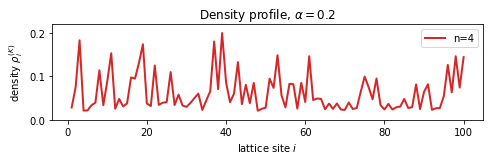

In [7]:
import matplotlib.pyplot as plt

# Create a figure 
plt.figure(figsize=(7,7/3))

# Plot the data

sites = [x + 1 for x in range(L)]
plt.plot(sites, profile[-1], linewidth=2, label='n=4' , color='C{}'.format(K-1))

maxrho = max(profile[-1]) # maximum density needed to set the y-axis range
plt.ylim(0,1.1*maxrho)

plt.xlabel(r'lattice site $i$', fontsize=10)
plt.ylabel(r'density $\rho_{i}^{(K)}$', fontsize=10)

# Set the title
plt.title(r'Density profile, $\alpha = $' +
             str(alpha), fontsize=12)

plt.legend(loc='best')
plt.tight_layout()

plt.show()

The cell below plots density profiles for all orders up to `K`, the maximum order of the PSA. This can be useful to see how the subsequent orders improve the estimate of the local density.

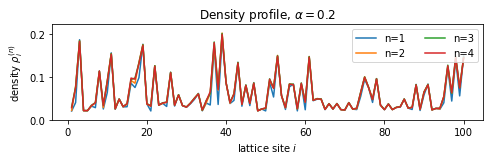

In [8]:
import matplotlib.pyplot as plt

# Create a figure 
plt.figure(figsize=(7,7/3))

# Plot the data

sites = [x + 1 for x in range(L)]

for n in range(1,K+1):
  plt.plot(sites, profile[n], label='n='+str(n), color='C{}'.format(n-1))

maxrho = max([max(x) for x in profile]) # maximum density needed to set the y-axis range
plt.ylim(0,1.1*maxrho)

plt.xlabel(r'lattice site $i$', fontsize=10)
plt.ylabel(r'density $\rho_{i}^{(n)}$', fontsize=10)

# Set the title
plt.title(r'Density profile, $\alpha = $' +
             str(alpha), fontsize=12)

plt.legend(loc='best', ncol=2)

#plt.savefig('figure_tutorial1.pdf', dpi=300)

plt.tight_layout()

plt.show()

As we see, for this particular set of hopping rates and this value of $\alpha$, the improvements are visible but not huge.

# 4. Plot mean density and current vs $\alpha$

The advantage of the PSA is that once the coefficients for given order `K` are computed, one can generate density and current for any value of $\alpha$. First, we define a list of values of $\alpha$.

In [9]:
# define a list with values of alpha to be computed

alpha_list = [round(0.05*x,2) for x in range(21)]

We then iterate over that list and compute mean density and current for each $\alpha$. To compute the mean density we use function `mean_density()` and to compute particle current we use function `current()`.

- `mean_density()` simply takes a list of values and returns the average of these values. With that we compute the average density $\rho$ from the profile $\rho(i)$.
- `current()` takes the list of coefficients $J_n$ and the value of $\alpha$. It then computes the value of the current $J(\alpha)$ for all the orders using Eq.(25a) of the affiliated paper: $J^{(k)}(\alpha)=\sum_{n=0}^{k} J_{n}\alpha^{n+1}$ for $k=0,\dots,K$. It returns the list $[J^{(0)},\ldots,J^{(K)}]$.

In the example below, for instance, `J[2]` contains the value of the current (for fixed $\alpha$) at the order 2 of the PSA approximation, as defined in the main text. In order to obtain mean density and current as functions of $\alpha$, we iterate on `alpha_list` and append the computed $\rho$ and $J$ to the lists `rho_alpha` and `J_alpha`.

In [10]:
# define empty lists where values of rho and J will be saved
# for example, rho_alpha[n] will contain rho(alpha) for the order n,...
rho_alpha = []
J_alpha = []

is_first = True

for alpha in alpha_list:

    profile2 = local_density(rhocoeff, alpha)

    for n in range(K+1):
    
        if is_first:
            rho_alpha.append([])
            J_alpha.append([])
            if n == K:
                is_first = False

        rho = mean_density(profile2[n])
        rho_alpha[n].append(rho)

    J = current(Jcoeff, alpha)
    
    n=0
    for j in J:
        J_alpha[n].append(j)
        n += 1

Finally, we plot $\rho(\alpha)$ and $J(\alpha)$ using different colors and styles for each order.

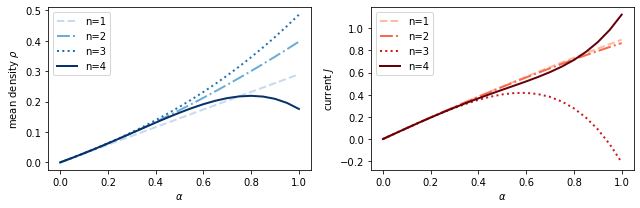

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Choose a colormap (you can change it to your preferred one)
color_map_density = cm.get_cmap('Blues')
color_map_current = cm.get_cmap('Reds')

# Create a new figure and axes for subfigure 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

# Plot the data

# Define a list of linestyles
linestyles = ['-', '--', '-.',':']

#### PLOT DENSITY
for n in range(1,K+1):

    line_color = color_map_density(n/K)
    
    # Cycle through the linestyles list
    line_style = linestyles[n % len(linestyles)]

    ax1.plot(alpha_list, rho_alpha[n], linewidth=2, label='n=' + str(n),color=line_color, linestyle = line_style)
    
# Set the x and y axis labels
ax1.set_xlabel(r'$\alpha$', fontsize=10)
ax1.set_ylabel(r'mean density $\rho$', fontsize=10)

# Add a legend
ax1.legend(loc='best', fontsize=10)

#### PLOT CURRENT
for n in range(1,K+1):

    line_color = color_map_current(n/K)
    
    # Cycle through the linestyles list
    line_style = linestyles[n % len(linestyles)]

    #if n != 0:
    ax2.plot(alpha_list, J_alpha[n], linewidth=2, label='n=' + str(n),
                color=line_color, linestyle=line_style)
    
# Set the x and y axis labels
ax2.set_xlabel(r'$\alpha$', fontsize=10)
ax2.set_ylabel(r'current $J$', fontsize=10)

# Adjust the plot layout
plt.tight_layout()

# Add a legend
ax2.legend(loc='best',fontsize=10)

#plt.savefig('figure_tutorial2.pdf', dpi=300)

# Show the plot
plt.show()

Plotting density and current vs $\alpha$ is useful for estimating values of $\alpha$ for which the PSA of given order $K$ is no longer a good approximation. As $\alpha$ is increased, the last term in the PSA begins to dominate, leading to wrong values of density and current. We know that the bounds are $0\leq \rho_i\leq 1$ for the density, and $0\leq J\leq \alpha$ for the current, so any value outside those bounds indicates that $\alpha$ is too big. 

We also expect the density and current to be non-decreasing in $\alpha$. Their values may eventually saturate when the slowest hopping rate becomes rate-limiting, but we do not expect them to deacrease in $\alpha$. This can be easily checked by computing the first derivative with respect to $\alpha$. For a given polynomial $f(x)=a_0+a_1x+\ldots+a_Kx^{K}$, the derivative is $f'(x)=a_1+\ldots+a_K K x^{K-1}$. We expect the PSA to fail for $\alpha$ for which the first derivative becomes negative. 

In the next cell, we find the smallest $\alpha$ in `alpha_list` for which any of the conditions above is not fulfilled. This value can be taken as an approximate $\alpha$ at which the PSA at this particular order is no longer realiable. In practice, it is best to consider $\alpha$ that is much smaller than this value. 

In [12]:
def derivative(a, x):
    result = 0
    n = 0
    for an in a:
        n += 1
        result += an * n * x**(n-1)
    return result

In [13]:
for alpha in alpha_list:
    
    # current
    J = current(Jcoeff, alpha)[-1]
    
    # derivative of the current
    dJ = derivative(Jcoeff, alpha)
    
    # mean density
    density_profile = local_density(rhocoeff, alpha)
    rho = mean_density(density_profile[-1])
    
    # derivative of the mean density
    mean_rhocoeff = []
    for order in range(1,K+1):
        rhocoeff_sum = 0
        for site in range(L):
            rhocoeff_sum += rhocoeff[site][order]
        mean_rhocoeff.append(rhocoeff_sum/L)
    drho = derivative(mean_rhocoeff, alpha)

    if (rho < 0):
        print('Mean density is less than 0 for alpha =',alpha)
        break
        
    if (rho > 1):
        print('Mean density is greater than 1 for alpha =',alpha)
        break
        
    if (drho < 0):
        print('Derivative of the mean density is less than 0 for alpha =',alpha)
        break
        
    if (J < 0):
        print('Particle current is less than 0 for alpha =',alpha)
        break
        
    if (J > alpha):
        print('Particle current is greater than alpha for alpha =',alpha)
        break
        
    if (dJ < 0):
        print('Derivative of the particle current is less than 0 for alpha =',alpha)
        break

Derivative of the mean density is less than 0 for alpha = 0.8
